# TP1-G1. Estimación espectral no-paramétrica

## Primero se muestra el código mínimo para el análisis del problema 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy import fft
from scipy.signal import butter, freqz, sosfreqz
from IPython.display import Audio

### Periodograma básico

In [2]:
def periodogram(x, N_FFT = 500000):
    w = fft.fftshift(fft.fftfreq(N_FFT, d=1.0)) * 2 * np.pi
    periodogram = np.abs(fft.fftshift(fft.fft(x, n = N_FFT)))**(2) / len(x) 
    return periodogram, w 

### Estimadores de autocorrelación

In [97]:
def biased_autocorr(x): 
    corr = signal.correlate(x, x, mode = 'full', method = 'fft')
    rxx_biased = corr / len(x)
    return rxx_biased

def biased_xcorr(x, y):
    xcorr = signal.correlate(x, y, mode = 'full')
    rxy_biased = xcorr / len(x)
    return rxy_biased

def unbiased_autocorr(x):
    corr = signal.correlate(x, x, mode = 'full')
    rxx_unbiased = np.array([corr[n] / (len(x) - np.abs(len(x) - 1 - n)) for n in range(0, len(corr))])
    return rxx_unbiased

### Periodogram Smoothing

In [4]:
# x: datos de tamaño N
# L: Siendo (L-1) tamaño del lag máximo de autocorrelación i.e. Rxx(l > |L-1|) = 0
# N_FFT: La cantidad de puntos que se usa en la FFT para visualizar el periodograma. Notar que en clase solemos hacerlo con N, pero podemos
# usar un valor mas chico a N para no hacerlo tan pesado al plot, aunque siempre debe ser mas grande que 2L-1 claramente. 
# Elegir N_FFT != N no "cambia" nada, simplemente se interpola con menos puntos
def periodogram_smoothing(x, L, N_FFT = 500000, window = 'bartlett'):
    N = len(x)
    rxx = biased_autocorr(x) # 2N - 1 de largo
    offset = N - 1 
    rxx = rxx[offset - (L-1) : offset + (L-1) + 1] # autocorr ventaneada o windowed con L
    window = signal.get_window(window = window, Nx=2*L-1, fftbins= False) 
    rxx_windowed = rxx*window

    Rxx = np.abs(fft.fftshift(fft.fft(rxx_windowed, n = N_FFT))) # (*) ver MARKDOWN ABAJO
    w = fft.fftshift(fft.fftfreq(N_FFT, d=1.0)) * 2 * np.pi

    return Rxx, w


### Periodogram Averaging

In [5]:
def periodogram_averaging(x, L, D, N_FFT = 500000, window = 'boxcar'): # procurar que N_FFT > 2L-1
    N = len(x)
    window_L = signal.get_window(window = window, Nx=L, fftbins= False) 
    num_segmentos = int(np.ceil((N - L)/D))     # Cantidad de segmentos con largo L
    if (N - L) % D == 0:
        num_segmentos += 1
    Rx = np.zeros(N_FFT)
    for i in range(0, num_segmentos):
        x_seg = x[i*D : i*D + L] * window_L
        Rx += 1/L * np.abs(fft.fftshift(fft.fft(x_seg, N_FFT)))**2

    Rx = Rx/num_segmentos
    w = fft.fftshift(fft.fftfreq(N_FFT, d=1.0)) * 2 * np.pi
    return Rx, w, num_segmentos

### Lectura del Dataset

In [6]:
class Data:
    def __init__(self, file):
        self.file = file
        self.dset = file['strain/Strain'][()]

In [7]:
import h5py

filenames = ['H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5', 'L-L1_GWOSC_4KHZ_R1-1126259447-32.hdf5', 
            'H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5', 'L-L1_GWOSC_4KHZ_R1-1126257415-4096.hdf5']
names = ['H1_32', 'L1_32', 'H1_4096', 'L1_4096']

data = {names[i]: Data(h5py.File(filename, 'r')) for (i, filename) in enumerate(filenames)}

fs = 1 / data['H1_32'].file['strain/Strain'].attrs['Xspacing']
print(fs)

4096.0


# Análisis exploratorio previo

Primero se visualizó la ASD ($\sqrt{PSD}$), notando la gran dominancia de las componentes de baja frecuencia ($< 30\text{Hz}$). A partir de esta observación, se realizó una aproximación de primer orden, considerando que la PSD (y ASD), es un pulso del tipo:
$$ 
PSD \approx A \cdot \Pi \left(\frac{f}{2\cdot 20 \text{Hz}}\right)
$$


<img src="psdruidoLIGO.png" width="400" height="400">

Por lo tanto, su función de auto correlación estaría dada por:

$$
   \mathcal{F}^{-1}_{discreta}[PSD] =  r_{xx}(l) = A \cdot 2 \cdot 20 \text{Hz} \cdot \text{sinc}(l\cdot 2 \cdot 20 \text{Hz})
$$

Está función tiene ceros en $l_{\text{ceros}} = k \frac{1}{40\text{Hz}} = k \cdot 25\text{ms}$

Por lo tanto, primero estimó su autocorrelación, usando el estimador de autocorrelación con bias, considerando una ventana de $14$ segundos. 

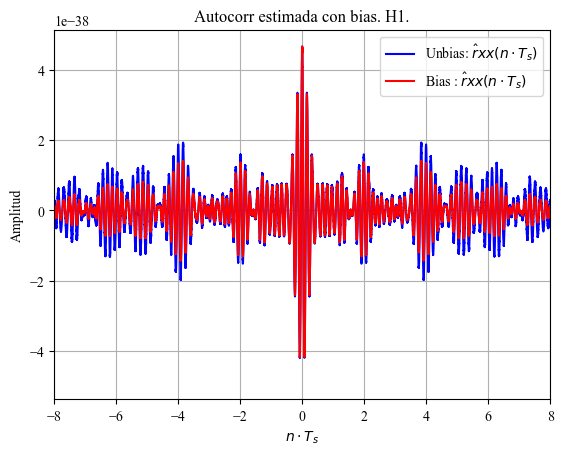

In [8]:
dset = data['H1_32'].dset
rxx = biased_autocorr(dset[0:int(14*fs)])
rxx_un = unbiased_autocorr(dset[0:int(14*fs)])

lags_time = signal.correlation_lags(len(dset[0:int(14*fs)]), len(dset[0:int(14*fs)])) / fs

import matplotlib as mpl
font_name = "Times New Roman"
mpl.rcParams['font.family'] = font_name

plt.figure()
plt.plot(lags_time, rxx_un, color = 'b', label = 'Unbias: $\hat{r}xx(n\cdot T_s)$')
plt.plot(lags_time, rxx, color = 'r', label = 'Bias : $\hat{r}xx(n\cdot T_s)$')
plt.legend()
plt.xlabel('$n\cdot T_s$')
plt.ylabel('Amplitud')
plt.title('Autocorr estimada con bias. H1.')
plt.xlim(-8, 8)
plt.grid()
plt.show()

Vemos que todavía se encuentran correlaciones en tiempos grandes ($t>4s$), aunque también notamos que a partir de los $2s$ comienza a bajar, mas bien, no es tan significativa como en el primer segundo. Esto es de utilidad para tener una noción de los valor de $L$ en periodogram smoothing que hay que elegir. Seguramente, recortar la autocorrelación en $100\text{ms}$, no tendrá sentido, dado que se perderá mucha información, ya sabiendo que el proceso tiene más "*inercia*", se requerirá de una ventana temporal más grande.

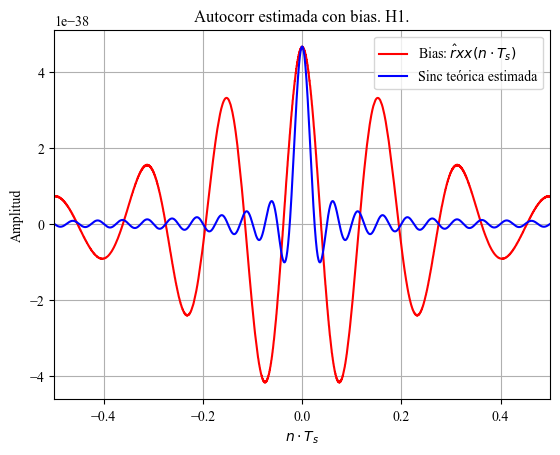

In [9]:
rxx = biased_autocorr(dset[0:int(14*fs)])
lags_time = signal.correlation_lags(len(dset[0:int(14*fs)]), len(dset[0:int(14*fs)])) / fs

z = np.where(lags_time == 0)[0][0]
n = lags_time[z - int(1*fs):z + int(1*fs)]

plt.figure()
plt.plot(lags_time, rxx, color = 'r', label = 'Bias: $\hat{r}xx(n\cdot T_s)$')
plt.plot(n, rxx[z] * np.sinc(n * 40), color = 'b', label = 'Sinc teórica estimada')
plt.legend()
plt.xlabel('$n\cdot T_s$')
plt.ylabel('Amplitud')
plt.title('Autocorr estimada con bias. H1.')
plt.xlim(-0.5, 0.5)
plt.grid()
plt.show()

Del gráfico anterior notamos que la PSD **no se puede modelar** simplemente como un pulso. Ni siquiera cambiando la constante de tiempo de la sinc, se pudo hacer fitear a la autocorrelación estimada. 

# Estimación del espectro de potencia de ruido para H1 y L1

# Periodograma clásico  

### Para Hanford

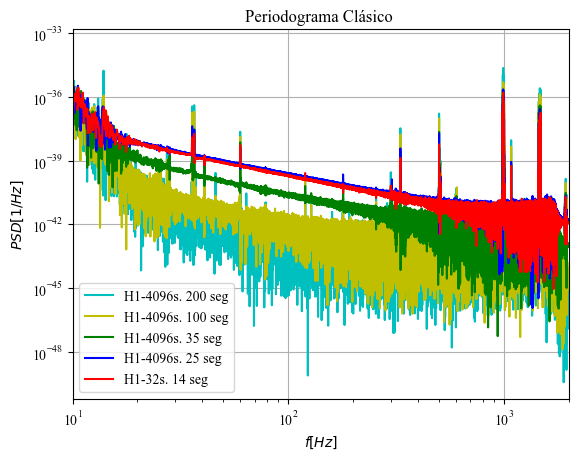

In [10]:
plt.figure()

x = data['H1_4096'].dset[int(300*fs):int(500*fs)]
Rxx, w = periodogram(x , N_FFT = np.max([50000, len(x)]))
f = w * fs / (2*np.pi)
plt.plot(f, Rxx, color = 'c', label = 'H1-4096s. 200 seg')

x = data['H1_4096'].dset[int(100*fs):int(200*fs)]
Rxx, w = periodogram(x , N_FFT = np.max([50000, len(x)]))
f = w * fs / (2*np.pi)
plt.plot(f, Rxx, color = 'y', label = 'H1-4096s. 100 seg')

x = data['H1_4096'].dset[0:int(35*fs)]
Rxx, w = periodogram(x , N_FFT = np.max([50000, len(x)]))
f = w * fs / (2*np.pi)
plt.plot(f, Rxx, color = 'g', label = 'H1-4096s. 35 seg')

x = data['H1_4096'].dset[0:int(20*fs)]
Rxx, w = periodogram(x , N_FFT = np.max([50000, len(x)]))
f = w * fs / (2*np.pi)
plt.plot(f, Rxx, color = 'b', label = 'H1-4096s. 25 seg')

x = data['H1_32'].dset[0:int(14*fs)]
Rxx, w = periodogram(x, N_FFT = np.max([50000, len(x)]))
f = w * fs / (2*np.pi)
plt.plot(f, Rxx, color = 'r', label = 'H1-32s. 14 seg')


plt.title('Periodograma Clásico ')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$f[Hz]$')
plt.ylabel('$PSD[1/Hz]$')
plt.legend()
plt.xlim(10, 2000)
plt.grid(True)
plt.show()

En el gráfico de arriba, notamos que ya tiempos bastante más grandes a los intuidos anteriormente con la autocorrelación son requeridos para lograr una estimación con poco bias. 
Sabemos que:
$$
    E[\hat{R}_x(e^{j\omega})] = \frac{1}{N} ( R_x \circledast R_w) (e^{j\omega})
$$

Siendo, 

$$
R_w(e^{j\omega}) = \mathcal{F}_{\text{discreta}}\left[\frac{1}{N}\cdot r_w(l)\right] 
$$
$$
r_w(l) = N\cdot \Lambda\left(\frac{l}{N}\right)
$$
Es la clave para entender la diferencia entre los gráficos. Si $N$ es más grande, el triangulo será mas ancho, es decir, la convolución circular se hará con un señal con un lóbulo más angosto, es decir, se asemejará a convolucionar con una delta.

La DTFT del triángulo está dada por:
$$
X(e^{j\omega}) = \frac{\sin{(N\omega/2)}}{N\sin{(\omega/2)}^2}
$$
Source: https://math.stackexchange.com/questions/119302/dtft-of-a-triangle-function-in-closed-form

Comprobamos:

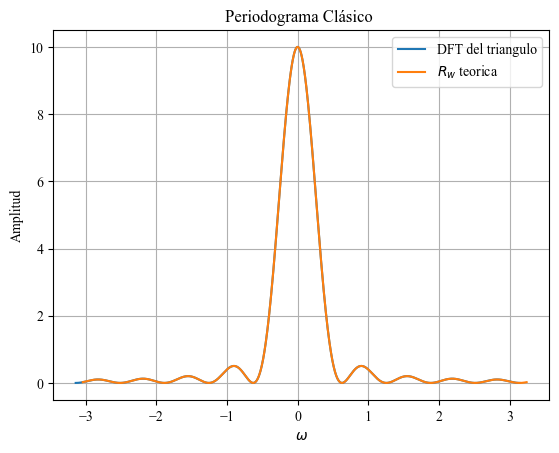

In [11]:
N = 10
sizefft = 100000
w = fft.fftshift((fft.fftfreq(sizefft))) * 2 * np.pi
X = fft.fftshift(fft.fft(signal.get_window(window="bartlett", Nx=2*N+1, fftbins= False), n = sizefft)) #* np.exp(1j*w*(sizefft-1)/2)

t = np.linspace(-np.pi+0.1, np.pi+0.1, 1023)
teorica = np.sin(N * t / 2)**2/(N*np.sin(t/2)**2)

plt.figure()
plt.grid()
plt.plot(w, np.abs(X), label = 'DFT del triangulo')
plt.plot(t, np.abs(teorica), label = '$R_w$ teorica')

plt.title('Periodograma Clásico ')
plt.xlabel('$\omega$')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.show()

Por lo tanto, el ancho de banda del lóbulo es de $\frac{4\pi}{N}$ rad/s.

Entonces podemos pensar que el valor esperado del periodgrama, es el periodograma pero filtrado con este lóbulo en el dominio espectral. 

Para $N=14\,\text{seg}\cdot f_s$, se tiene que el ancho del lóbulo en Hz es de $\Delta f = \frac{2}{N}\cdot 4096 \text{Hz} = \frac{2}{\text{Tiempo de la ventana}} = 142\text{mHz}$

Es mucha resolución espectral, sin embargo, para una ventana de $14$ segundos, no es suficiente para obtener una buena estimación.

###  Para Livingston

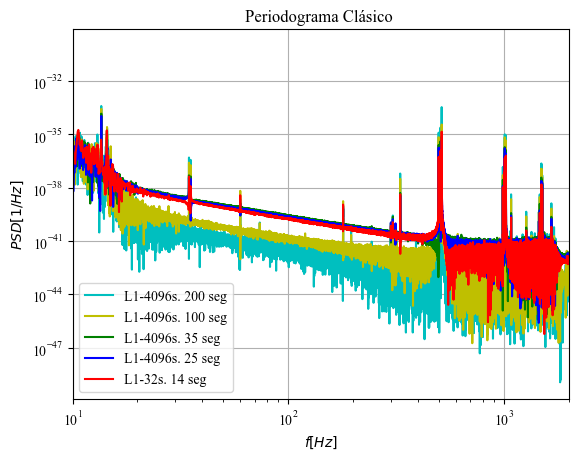

In [12]:
plt.figure()

x = data['L1_4096'].dset[int(300*fs):int(500*fs)]
Rxx, w = periodogram(x , N_FFT = np.max([50000, len(x)]))
f = w * fs / (2*np.pi)
plt.plot(f, Rxx, color = 'c', label = 'L1-4096s. 200 seg')

x = data['L1_4096'].dset[int(100*fs):int(200*fs)]
Rxx, w = periodogram(x , N_FFT = np.max([50000, len(x)]))
f = w * fs / (2*np.pi)
plt.plot(f, Rxx, color = 'y', label = 'L1-4096s. 100 seg')

x = data['L1_4096'].dset[0:int(35*fs)]
Rxx, w = periodogram(x , N_FFT = np.max([50000, len(x)]))
f = w * fs / (2*np.pi)
plt.plot(f, Rxx, color = 'g', label = 'L1-4096s. 35 seg')

x = data['L1_4096'].dset[0:int(25*fs)]
Rxx, w = periodogram(x , N_FFT = np.max([50000, len(x)]))
f = w * fs / (2*np.pi)
plt.plot(f, Rxx, color = 'b', label = 'L1-4096s. 25 seg')

x = data['L1_32'].dset[0:int(14*fs)]
Rxx, w = periodogram(x, N_FFT = np.max([50000, len(x)]))
f = w * fs / (2*np.pi)
plt.plot(f, Rxx, color = 'r', label = 'L1-32s. 14 seg')


plt.title('Periodograma Clásico ')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$f[Hz]$')
plt.ylabel('$PSD[1/Hz]$')
plt.legend()
plt.xlim(10, 2000)
plt.grid(True)
plt.show()

Resultados similares a Hanford son observados


## Comparando H1 y L1

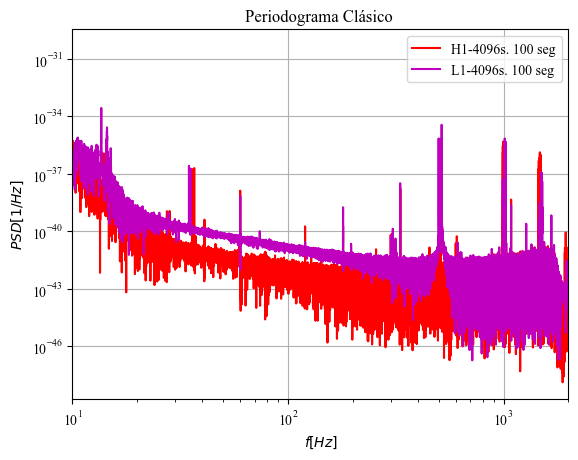

In [38]:
plt.figure()


x = data['H1_4096'].dset[int(100*fs):int(200*fs)]
Rxx, w = periodogram(x , N_FFT = np.max([50000, len(x)]))
f = w * fs / (2*np.pi)
plt.plot(f, Rxx, color = 'r', label = 'H1-4096s. 100 seg')

x = data['L1_4096'].dset[int(100*fs):int(200*fs)]
Rxx, w = periodogram(x , N_FFT = np.max([50000, len(x)]))
f = w * fs / (2*np.pi)
plt.plot(f, Rxx, color = 'm', label = 'L1-4096s. 100 seg')



plt.title('Periodograma Clásico ')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$f[Hz]$')
plt.ylabel('$PSD[1/Hz]$')
plt.legend()
plt.xlim(10, 2000)
plt.grid(True)
plt.show()

Se observa que H1 se estima con menos bias que L1, para la misma ventana temporal

# Periodogram Smoothing

### Para Hanford

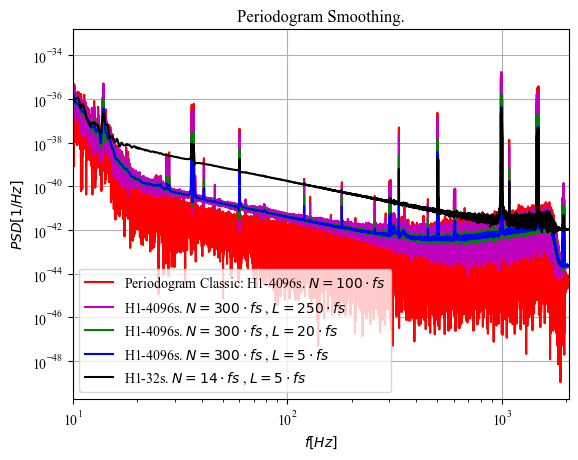

In [14]:
plt.figure()

x = data['H1_4096'].dset[0:int(300*fs)]
Rxx, w = periodogram(x , N_FFT = np.max([50000, len(x)]))
f = w * fs / (2*np.pi)
plt.plot(f, Rxx, color = 'r', label = 'Periodogram Classic: H1-4096s. $N = 100\cdot fs$ ')

L_seg = 250
L = int(L_seg * fs)
x = data['H1_4096'].dset[int(0):int(300*fs)]
Rxx, w = periodogram_smoothing(x, L, N_FFT = np.max([50000, 2*len(x)+ 1]), window = 'parzen')
f = w * fs / (2*np.pi)
plt.plot(f, Rxx, color = 'm', label = 'H1-4096s. $N = 300\cdot fs$ , $L = 250\cdot fs$')

L_seg = 20
L = int(L_seg * fs)
x = data['H1_4096'].dset[int(0):int(300*fs)]
Rxx, w = periodogram_smoothing(x, L, N_FFT = np.max([50000, 2*len(x)+ 1]), window = 'parzen')
f = w * fs / (2*np.pi)
plt.plot(f, Rxx, color = 'g', label = 'H1-4096s. $N = 300\cdot fs$ , $L = 20\cdot fs$')


L_seg = 5
L = int(L_seg * fs)
x = data['H1_4096'].dset[int(0):int(300*fs)]
Rxx, w = periodogram_smoothing(x, L, N_FFT = np.max([50000, 2*len(x)+ 1]), window = 'parzen')
f = w * fs / (2*np.pi)
plt.plot(f, Rxx, color = 'b', label = 'H1-4096s. $N = 300\cdot fs$ , $L = 5\cdot fs$')

L_seg = 5
L = int(L_seg * fs)
x = data['H1_32'].dset[int(0):int(14*fs)]
Rxx, w = periodogram_smoothing(x, L, N_FFT = np.max([50000, 2*len(x)+ 1]), window = 'parzen')
f = w * fs / (2*np.pi)
plt.plot(f, Rxx, color = 'k', label = 'H1-32s. $N = 14\cdot fs$ , $L = 5\cdot fs$')


plt.title('Periodogram Smoothing.')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$f[Hz]$')
plt.ylabel('$PSD[1/Hz]$')
plt.legend(loc = 'lower left')
plt.xlim(10, fs/2)
plt.grid(True)
plt.show()

Del gráfico de arriba, vemos que todos los periodogram smoothing tienen más bias que el periodogram classic, aunque esto quizás solo es molesto en el rango de $20\text{Hz} 300\text{Hz}$

El dataset de $32$ segundos, tiene el problema de que el evento en la mitad del segmento limita el análisis a solo $14$ segundos. Concatenar en un solo segmento que excluya el evento no es una buena idea, dado que se tiene un escalón de correlación.

Para $N=300 \cdot f_s$, $L = 5 \cdot fs$, se tiene una resolución espectral de $\Delta f = \frac{2}{2L_{\text{segundos}}} = 0.2 \text{Hz}$

### Para Livingston

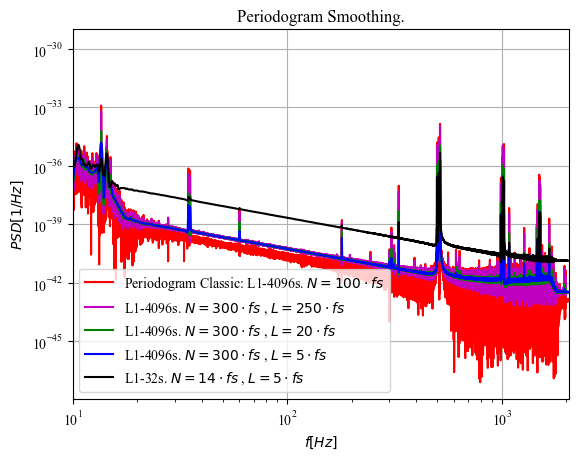

In [15]:
plt.figure()

x = data['L1_4096'].dset[0:int(300*fs)]
Rxx, w = periodogram(x , N_FFT = np.max([50000, len(x)]))
f = w * fs / (2*np.pi)
plt.plot(f, Rxx, color = 'r', label = 'Periodogram Classic: L1-4096s. $N = 100\cdot fs$ ')

L_seg = 250
L = int(L_seg * fs)
x = data['L1_4096'].dset[int(0):int(300*fs)]
Rxx, w = periodogram_smoothing(x, L, N_FFT = np.max([50000, 2*len(x)+ 1]), window = 'parzen')
f = w * fs / (2*np.pi)
plt.plot(f, Rxx, color = 'm', label = 'L1-4096s. $N = 300\cdot fs$ , $L = 250\cdot fs$')

L_seg = 20
L = int(L_seg * fs)
x = data['L1_4096'].dset[int(0):int(300*fs)]
Rxx, w = periodogram_smoothing(x, L, N_FFT = np.max([50000, 2*len(x)+ 1]), window = 'parzen')
f = w * fs / (2*np.pi)
plt.plot(f, Rxx, color = 'g', label = 'L1-4096s. $N = 300\cdot fs$ , $L = 20\cdot fs$')


L_seg = 5
L = int(L_seg * fs)
x = data['L1_4096'].dset[int(0):int(300*fs)]
Rxx, w = periodogram_smoothing(x, L, N_FFT = np.max([50000, 2*len(x)+ 1]), window = 'parzen')
f = w * fs / (2*np.pi)
plt.plot(f, Rxx, color = 'b', label = 'L1-4096s. $N = 300\cdot fs$ , $L = 5\cdot fs$')

L_seg = 5
L = int(L_seg * fs)
x = data['L1_32'].dset[int(0):int(14*fs)]
Rxx, w = periodogram_smoothing(x, L, N_FFT = np.max([50000, 2*len(x)+ 1]), window = 'parzen')
f = w * fs / (2*np.pi)
plt.plot(f, Rxx, color = 'k', label = 'L1-32s. $N = 14\cdot fs$ , $L = 5\cdot fs$')


plt.title('Periodogram Smoothing.')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$f[Hz]$')
plt.ylabel('$PSD[1/Hz]$')
plt.legend(loc = 'lower left')
plt.xlim(10, fs/2)
plt.grid(True)
plt.show()

*Eadem* conclusiones

# Periodogram Averaging

### Para Hanford

K= 37
K= 37
K= 51
K= 160
K= 816


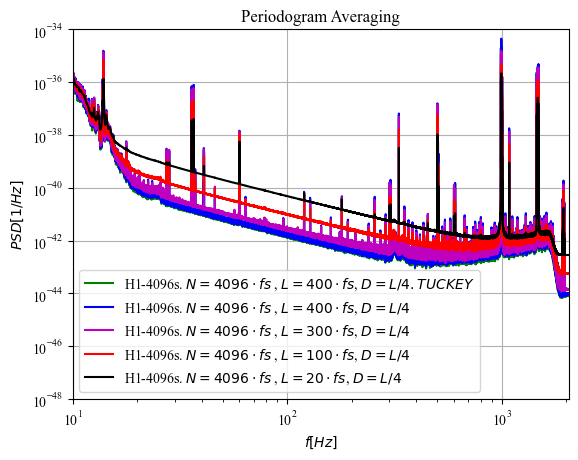

In [47]:
plt.figure()

from scipy.signal.windows import tukey
L_seg = 400
L = int(L_seg * fs)
D = int(L/4)
window_tuk = tukey(int(4096*fs), alpha =  0.3)
x = data['H1_4096'].dset[int(0):int(4096*fs)] * window_tuk
Rxx, w, num = periodogram_averaging(x, L, D, N_FFT = np.max([50000, L]))
print('K=', num)
f = w * fs / (2*np.pi)
plt.plot(f, Rxx, color = 'g', label = 'H1-4096s. $N = 4096\cdot fs$ , $L = 400\cdot fs$, $D=L/4. TUCKEY$')

L_seg = 400
L = int(L_seg * fs)
D = int(L/4)
x = data['H1_4096'].dset[int(0):int(4096*fs)] 
Rxx, w, num = periodogram_averaging(x, L, D, N_FFT = np.max([50000, L]))
print('K=', num)
f = w * fs / (2*np.pi)
plt.plot(f, Rxx, color = 'b', label = 'H1-4096s. $N = 4096\cdot fs$ , $L = 400\cdot fs$, $D=L/4$')


L_seg = 300
L = int(L_seg * fs)
D = int(L/4)
x = data['H1_4096'].dset[int(0):int(4096*fs)] 
Rxx, w, num = periodogram_averaging(x, L, D, N_FFT = np.max([50000, L]))
print('K=', num)
f = w * fs / (2*np.pi)
plt.plot(f, Rxx, color = 'm', label = 'H1-4096s. $N = 4096\cdot fs$ , $L = 300\cdot fs$, $D=L/4$')

L_seg = 100
L = int(L_seg * fs)
D = int(L/4)
x = data['H1_4096'].dset
Rxx, w, num = periodogram_averaging(x, L, D, N_FFT = np.max([50000, L]))
print('K=', num)
f = w * fs / (2*np.pi)
plt.plot(f, Rxx, color = 'r', label = 'H1-4096s. $N = 4096\cdot fs$ , $L = 100\cdot fs$, $D=L/4$')

L_seg = 20
L = int(L_seg * fs)
D = int(L/4)
x = data['H1_4096'].dset
Rxx, w, num = periodogram_averaging(x, L, D, N_FFT = np.max([50000, L]))
print('K=', num)
f = w * fs / (2*np.pi)
plt.plot(f, Rxx, color = 'k', label = 'H1-4096s. $N = 4096\cdot fs$ , $L = 20\cdot fs$, $D=L/4$')

plt.title('Periodogram Averaging')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$f[Hz]$')
plt.ylabel('$PSD[1/Hz]$')
plt.legend(loc = 'lower left')
plt.xlim(10, fs/2)
plt.ylim(10**(-48), 10**(-34))
plt.grid(True)
plt.show()

En referencia al gráfico de arriba. Todas las curvas usaron el dataset completo (se desprecia el evento para tantas muestras). Lo más importante a ver, es el bias para la curva negra y roja. A pesar de que tomaron mas ventanas para promediar (por lo tanto menos varianza), el bias resulta significativo. Un análisis similar a los anteriores periodogramas. El valor esperado es una convolución circular con $R_w$ (misma expresión que la mostrada con periodograma clásico). 

### Para Livingston

K= 37
K= 37
K= 51
K= 160
K= 816


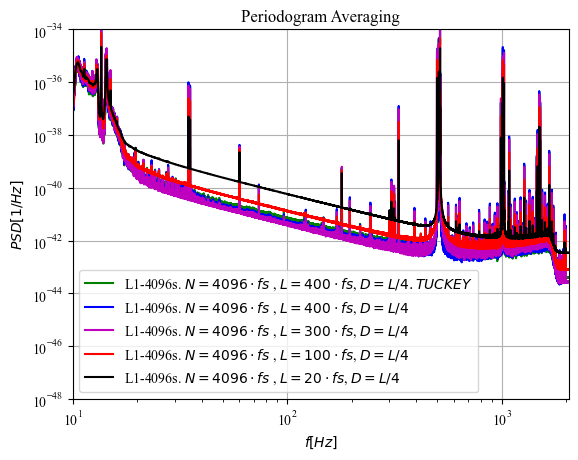

In [49]:
plt.figure()

from scipy.signal.windows import tukey
L_seg = 400
L = int(L_seg * fs)
D = int(L/4)
window_tuk = tukey(int(4096*fs), alpha =  0.3)
x = data['L1_4096'].dset[int(0):int(4096*fs)] * window_tuk
Rxx, w, num = periodogram_averaging(x, L, D, N_FFT = np.max([50000, L]))
print('K=', num)
f = w * fs / (2*np.pi)
plt.plot(f, Rxx, color = 'g', label = 'L1-4096s. $N = 4096\cdot fs$ , $L = 400\cdot fs$, $D=L/4. TUCKEY$')

L_seg = 400
L = int(L_seg * fs)
D = int(L/4)
x = data['L1_4096'].dset[int(0):int(4096*fs)] 
Rxx, w, num = periodogram_averaging(x, L, D, N_FFT = np.max([50000, L]))
print('K=', num)
f = w * fs / (2*np.pi)
plt.plot(f, Rxx, color = 'b', label = 'L1-4096s. $N = 4096\cdot fs$ , $L = 400\cdot fs$, $D=L/4$')

L_seg = 300
L = int(L_seg * fs)
D = int(L/4)
x = data['L1_4096'].dset[int(0):int(4096*fs)] 
Rxx, w, num = periodogram_averaging(x, L, D, N_FFT = np.max([50000, L]))
print('K=', num)
f = w * fs / (2*np.pi)
plt.plot(f, Rxx, color = 'm', label = 'L1-4096s. $N = 4096\cdot fs$ , $L = 300\cdot fs$, $D=L/4$')

L_seg = 100
L = int(L_seg * fs)
D = int(L/4)
x = data['L1_4096'].dset
Rxx, w, num = periodogram_averaging(x, L, D, N_FFT = np.max([50000, L]))
print('K=', num)
f = w * fs / (2*np.pi)
plt.plot(f, Rxx, color = 'r', label = 'L1-4096s. $N = 4096\cdot fs$ , $L = 100\cdot fs$, $D=L/4$')

L_seg = 20
L = int(L_seg * fs)
D = int(L/4)
x = data['L1_4096'].dset
Rxx, w, num = periodogram_averaging(x, L, D, N_FFT = np.max([50000, L]))
print('K=', num)
f = w * fs / (2*np.pi)
plt.plot(f, Rxx, color = 'k', label = 'L1-4096s. $N = 4096\cdot fs$ , $L = 20\cdot fs$, $D=L/4$')

plt.title('Periodogram Averaging')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$f[Hz]$')
plt.ylabel('$PSD[1/Hz]$')
plt.legend(loc = 'lower left')
plt.xlim(10, fs/2)
plt.ylim(10**(-48), 10**(-34))
plt.grid(True)
plt.show()

Comparemos ahora para distintos valores de $D$, esto impactará en $K$, la cantidad de ventanas usadas

K= 11
K= 13
K= 26
K= 51


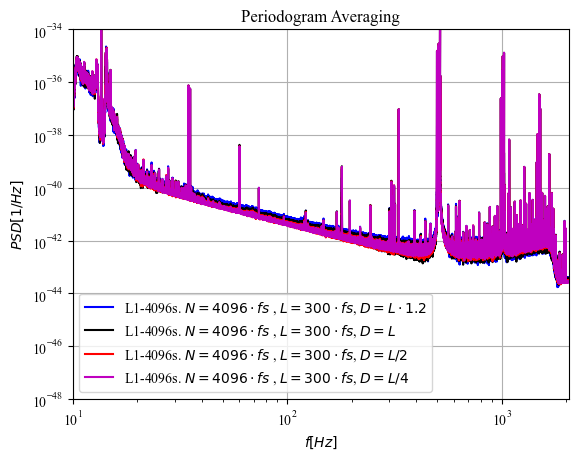

In [53]:
plt.figure()

L_seg = 300
L = int(L_seg * fs)
D = int(L*1.2)
x = data['L1_4096'].dset[int(0):int(4096*fs)] 
Rxx, w, num = periodogram_averaging(x, L, D, N_FFT = np.max([50000, L]))
print('K=', num)
f = w * fs / (2*np.pi)
plt.plot(f, Rxx, color = 'b', label = 'L1-4096s. $N = 4096\cdot fs$ , $L = 300\cdot fs$, $D=L\cdot 1.2$')

L_seg = 300
L = int(L_seg * fs)
D = int(L)
x = data['L1_4096'].dset[int(0):int(4096*fs)] 
Rxx, w, num = periodogram_averaging(x, L, D, N_FFT = np.max([50000, L]))
print('K=', num)
f = w * fs / (2*np.pi)
plt.plot(f, Rxx, color = 'k', label = 'L1-4096s. $N = 4096\cdot fs$ , $L = 300\cdot fs$, $D=L$')

L_seg = 300
L = int(L_seg * fs)
D = int(L/2)
x = data['L1_4096'].dset[int(0):int(4096*fs)] 
Rxx, w, num = periodogram_averaging(x, L, D, N_FFT = np.max([50000, L]))
print('K=', num)
f = w * fs / (2*np.pi)
plt.plot(f, Rxx, color = 'r', label = 'L1-4096s. $N = 4096\cdot fs$ , $L = 300\cdot fs$, $D=L/2$')

L_seg = 300
L = int(L_seg * fs)
D = int(L/4)
x = data['L1_4096'].dset[int(0):int(4096*fs)] 
Rxx, w, num = periodogram_averaging(x, L, D, N_FFT = np.max([50000, L]))
print('K=', num)
f = w * fs / (2*np.pi)
plt.plot(f, Rxx, color = 'm', label = 'L1-4096s. $N = 4096\cdot fs$ , $L = 300\cdot fs$, $D=L/4$')


plt.title('Periodogram Averaging')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$f[Hz]$')
plt.ylabel('$PSD[1/Hz]$')
plt.legend(loc = 'lower left')
plt.xlim(10, fs/2)
plt.ylim(10**(-48), 10**(-34))
plt.grid(True)
plt.show()

Resulta despreciable la variación de la varianza de ruido para todos los casos. Esto se debe a que las ventanas estas correlacionadas por lo tanto no se cumple la hipótesis de incorrelación, ergo, la varianza no disminuye en $1/K$

# Selección del periodograma



El periodograma clásico es descartado, por la elevada varianza que presenta. 

K= 254
K= 25
K= 80


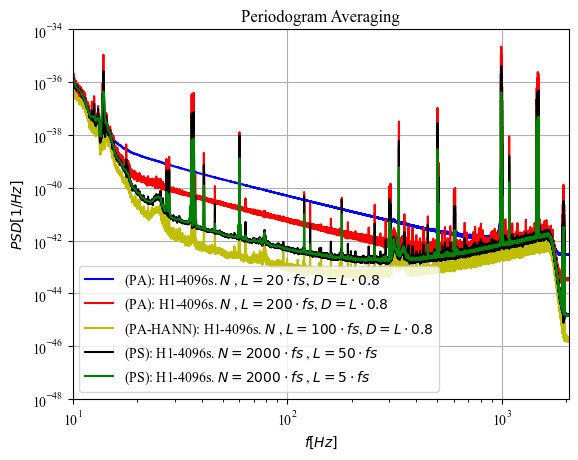

In [74]:
plt.figure()

L_seg = 20
L = int(L_seg * fs)
D = int(L*0.8)
x =  np.hstack((data['H1_4096'].dset[int(0):int(2040*fs)], data['H1_4096'].dset[int(2060*fs):int(4096*fs)]))    
Rxx, w, num = periodogram_averaging(x, L, D, N_FFT = np.max([50000, L]))
print('K=', num)
f = w * fs / (2*np.pi)
plt.plot(f, Rxx, color = 'b', label = '(PA): H1-4096s. $N \approx 4096\cdot fs$ , $L = 20\cdot fs$, $D=L\cdot 0.8$')

L_seg = 200
L = int(L_seg * fs)
D = int(L*0.8)
x =  np.hstack((data['H1_4096'].dset[int(0):int(2040*fs)], data['H1_4096'].dset[int(2060*fs):int(4096*fs)]))    
Rxx, w, num = periodogram_averaging(x, L, D, N_FFT = np.max([50000, L]))
print('K=', num)
f = w * fs / (2*np.pi)
plt.plot(f, Rxx, color = 'r', label = '(PA): H1-4096s. $N \approx 4096\cdot fs$ , $L = 200\cdot fs$, $D=L\cdot 0.8$')

L_seg = 100
L = int(L_seg * fs)
D = int(L*0.5)
x =  np.hstack((data['H1_4096'].dset[int(0):int(2040*fs)], data['H1_4096'].dset[int(2060*fs):int(4096*fs)]))  
Rxx, w, num = periodogram_averaging(x, L, D, N_FFT = np.max([50000, L]), window = 'hann')
print('K=', num)
f = w * fs / (2*np.pi)
plt.plot(f, Rxx, color = 'y', label = '(PA-HANN): H1-4096s. $N \approx 4096\cdot fs$ , $L = 100\cdot fs$, $D=L\cdot 0.8$')

L_seg = 50
L = int(L_seg * fs)
x = data['H1_4096'].dset[int(0):int(2000*fs)]
Rxx, w = periodogram_smoothing(x, L, N_FFT = np.max([50000, 2*(L)+ 1]), window = 'parzen')
f = w * fs / (2*np.pi)
plt.plot(f, Rxx, color = 'k', label = '(PS): H1-4096s. $N = 2000\cdot fs$ , $L = 50\cdot fs$')

L_seg = 5
L = int(L_seg * fs)
x = data['H1_4096'].dset[int(0):int(2000*fs)]
Rxx, w = periodogram_smoothing(x, L, N_FFT = np.max([50000, 2*(L)+ 1]), window = 'parzen')
f = w * fs / (2*np.pi)
plt.plot(f, Rxx, color = 'g', label = '(PS): H1-4096s. $N = 2000\cdot fs$ , $L = 5\cdot fs$')

plt.title('Periodogram Averaging')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$f[Hz]$')
plt.ylabel('$PSD[1/Hz]$')
plt.legend(loc = 'lower left')
plt.xlim(10, fs/2)
plt.ylim(10**(-48), 10**(-34))
plt.grid(True)
plt.show()

El mejor método para estos dataset, es el **periodogram smoothing**, el cual logra la menor bias y varianza. Para que el periodogram averaging alcance similares valores de bias, se requiere aumentar la ventana de datos ($L$), pero esto produce que se promedien menos periodogramas, asi aumentando su varianza. El uso del parámetro de avance ($D$), no produce cambios significativos al ser reducido por debajo de ($L$) con el objetivo de aumentar la cantidad de periodogramas, como se mencionó anteriormente, esto se debe a que los periodogramas no están incorrelacionados. Incluso teniendo la posibilidad en periodogram averaging de usar la totalidad de los $4096$ segundos (salvo por los segundos del evento), a diferencia del periodogram smoothing donde solo se usó la primera mitad (se comentó el porque de esto el la sección correspondiente).

Es importante comprender, que estas diferencias de Bias, son completamente determinadas por el tipo de ventana usado. Si hablamos de bias, debemos analizar el valor esperado. Tanto PA como PS, tienen la misma expresión de convolución circular (bajo ciertas hipótesis), sobre el valor esperado. En PS, la $Rx$ se convoluciona circularmente con $W_a$, la DTFT de la ventana aplicada a la autocorrelación estimada (Parzen o Bartlett) , mientras que en PA, esa $W_a$ es la DTFT de de la ventana de datos, para lo estudiado en clase, es una ventana rectangular. Y ya sabemos, las deficiencias de la ventana cuadrada (leakage espectral), por lo tanto, no resulta escabroso pensar en usar otro tipo de ventana. Para PA, no estamos limitados a usar Parzen o Bartlett, podemos usar cualquier tipo de ventana que resulta conveniente. En el gráfico de arriba, se ventaneó el PA, con una ventana de Hann, notando una drástica disminución del bias. 

# Comparación de H1 con L1

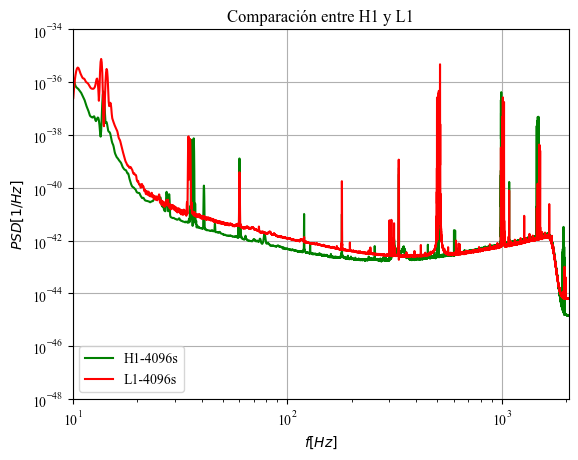

In [83]:
plt.figure()

L_seg = 5
L = int(L_seg * fs)
x = data['H1_4096'].dset[int(0):int(2000*fs)]
Rxx, w = periodogram_smoothing(x, L, N_FFT = np.max([50000, 2*(L)+ 1]), window = 'parzen')
f = w * fs / (2*np.pi)
plt.plot(f, Rxx, color = 'g', label = 'H1-4096s')


L_seg = 5
L = int(L_seg * fs)
x = data['L1_4096'].dset[int(0):int(2000*fs)]
Rxx, w = periodogram_smoothing(x, L, N_FFT = np.max([50000, 2*(L)+ 1]), window = 'parzen')
f = w * fs / (2*np.pi)
plt.plot(f, Rxx, color = 'r', label = 'L1-4096s')


plt.title('Comparación entre H1 y L1')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$f[Hz]$')
plt.ylabel('$PSD[1/Hz]$')
plt.legend(loc = 'lower left')
plt.xlim(10, fs/2)
plt.ylim(10**(-48), 10**(-34))
plt.grid(True)
plt.show()

Se observa que varios picos, se condicen, estos picos son fuentes permanentes de ruido puntuales como maquinas vibrando a frecuencias puntuales, según papers relacionados. Se obsera un cierto bias en los dos periodogramas 

<img src="psd_tutorials.png" width="600" >

# Whitening

La solución propuesta, esta inspirada en el tutorial https://colab.research.google.com/github/losc-tutorial/Data_Guide/blob/master/Guide_Notebook.ipynb#scrollTo=Swhs0WD1Sayb. 

Para realizar el whitening, estiman la PSD (sin el evento), luego a la ventana de datos que contiene el evento, le aplican un filtro con transferencia $|H(e^{j\omega})| = \frac{1}{\sqrt{(PSD)}}$, de forma tal que la PSD resultante, termina siendo $R_{\text{output-output}}(e^{j\omega}) = R_{\text{input-input}}(e^{j\omega}) |H(e^{j\omega})|^2 = 1$. Este filtrado se realiza con producto de DFT. Por lo tanto, en tiempo, es como si, se tuviese una entrada circular. Posteriormente, un filtro pasabanda de fase cero (para evitar distorsión por fase), es utilizado para obtener la señal del evento. 

C:\Users\sch_b\AppData\Local\Temp\ipykernel_7068\96378192.py:17: RuntimeWarning: divide by zero encountered in log10
  plt.plot(frequencies, 20 * np.log10(magnitude_response))


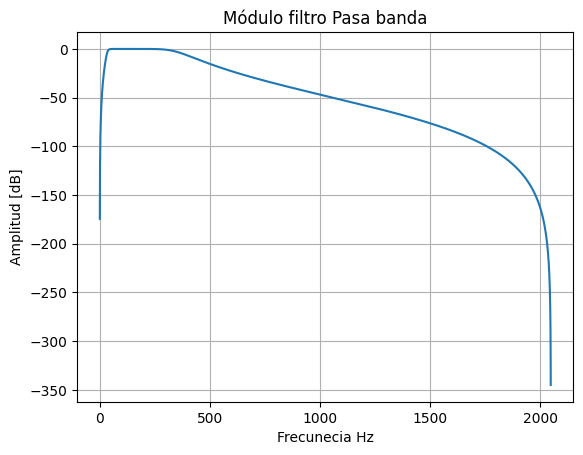

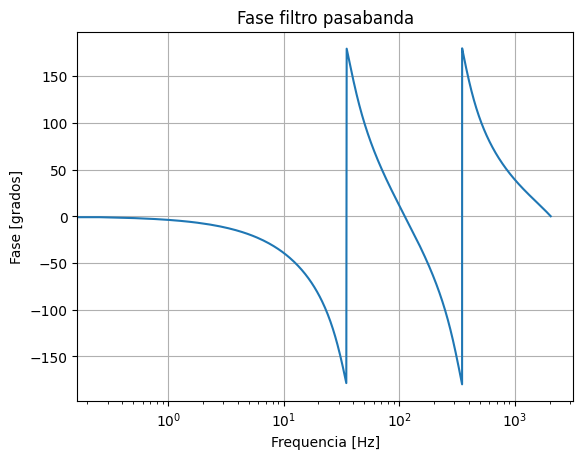

In [145]:
low_cutoff = 35
high_cutoff = 350

nyq = 0.5 * fs
low_cutoff_norm = low_cutoff / nyq
high_cutoff_norm = high_cutoff / nyq

sos = butter(N=4, Wn=[low_cutoff_norm, high_cutoff_norm], btype='band', output='sos')
b, a = butter(N=4, Wn=[low_cutoff_norm, high_cutoff_norm], btype='band')

frequencies, response = sosfreqz(sos, worN=8000, fs=fs)

magnitude_response = np.abs(response)
phase_response = np.angle(response, deg=True)

plt.figure()
plt.plot(frequencies, 20 * np.log10(magnitude_response))
plt.xlabel('Frecunecia Hz')
plt.ylabel('Amplitud [dB]')
plt.grid(True)
plt.title('Módulo filtro Pasa banda')
plt.show()

plt.figure()
plt.semilogx(frequencies, phase_response)
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Fase [grados]')
plt.grid(True)
plt.title('Fase filtro pasabanda')
plt.show()


In [146]:
L_seg = 5
L = int(L_seg * fs)
x = data['H1_4096'].dset[int(0):int(2000*fs)]
Rxx, w = periodogram_smoothing(x, L, N_FFT = np.max([50000, 2*(L)+ 1]), window = 'parzen')
f = w * fs / (2*np.pi)

""" L_seg = 100
L = int(L_seg * fs)
D = int(L*0.5)
x =  np.hstack((data['H1_4096'].dset[int(0):int(2040*fs)], data['H1_4096'].dset[int(2060*fs):int(4096*fs)]))  
Rxx, w, num = periodogram_averaging(x, L, D, N_FFT = np.max([50000, L]), window = 'hann')
print('K=', num)
f = w * fs / (2*np.pi) """


" L_seg = 100\nL = int(L_seg * fs)\nD = int(L*0.5)\nx =  np.hstack((data['H1_4096'].dset[int(0):int(2040*fs)], data['H1_4096'].dset[int(2060*fs):int(4096*fs)]))  \nRxx, w, num = periodogram_averaging(x, L, D, N_FFT = np.max([50000, L]), window = 'hann')\nprint('K=', num)\nf = w * fs / (2*np.pi) "

c:\Users\sch_b\OneDrive\Documentos\PASA\.PASA\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\sch_b\OneDrive\Documentos\PASA\.PASA\Lib\site-packages\IPython\lib\display.py:172: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


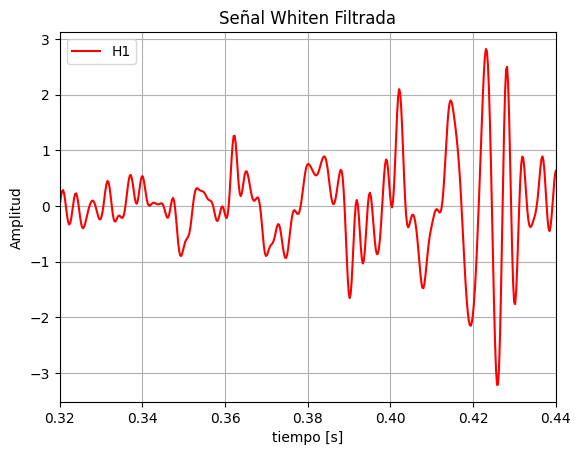

In [147]:
from IPython.display import Audio
from scipy.signal.windows import tukey

def whiten(data : Data, event = True):
    if event == True:
        event_time = 1126259462
        deltaT = 2
        start_time = data.file['quality/injections/Injmask'].attrs['Xstart']
        te = int((event_time-start_time)*fs)
        event_samples = data.dset[te-int(deltaT*fs):te+int(deltaT*fs)]
        Nt = len(event_samples) # len(w)
    else:
        deltaT = 300
        event_samples = data.dset[:int(2*deltaT*fs)]
        Nt = len(event_samples) # len(w)

    window_tuk = tukey(int(deltaT*2*fs), alpha =  0.3)
    freqs = fft.fftshift(fft.fftfreq(Nt, 1))

    hf = fft.fftshift(fft.fft(event_samples * window_tuk, n = Nt))
    norm = 1./np.sqrt(1./(1*2))
    white_hf = hf / np.sqrt(np.interp(freqs, f/fs, Rxx)) * norm
    white_ht = fft.ifft(fft.ifftshift(white_hf), n=Nt)  

    return white_ht

plt.close()
plt.figure()
plt.cla()

filtered_signal_phase_H1 = signal.filtfilt(b, a, whiten(data['H1_32']))
filtered_signal_phase2_L1 = signal.filtfilt(b, a, whiten(data['L1_32']))

time = np.arange(-len(filtered_signal_phase_H1)/2, len(filtered_signal_phase_H1)/2)/fs
plt.plot(time, filtered_signal_phase_H1, color = 'r', label = 'H1')
#plt.plot(time, filtered_signal_phase2_L1, color = 'b')

Audio((filtered_signal_phase - np.mean(filtered_signal_phase))/ np.max((filtered_signal_phase - np.mean(filtered_signal_phase))), rate=fs)
plt.xlabel('tiempo [s]')
plt.ylabel('Amplitud')
plt.legend()
plt.title('Señal Whiten Filtrada')
plt.xlim(0.32, 0.44)
plt.grid(True)
plt.show()

Se visualiza el evento ocurrir

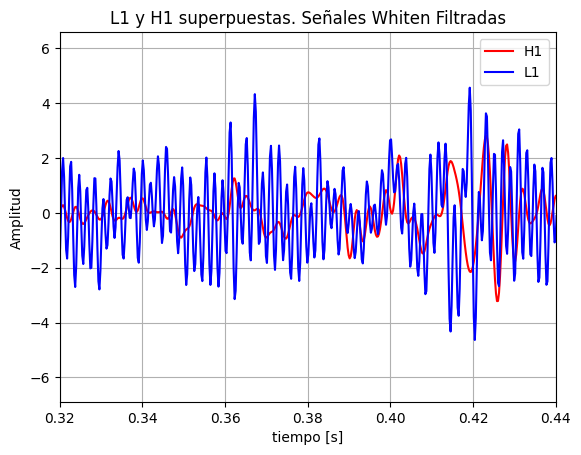

In [148]:
plt.close()
plt.figure()
plt.cla()

plt.plot(time, filtered_signal_phase_H1, color = 'r', label = 'H1')
plt.plot(time, filtered_signal_phase2_L1, color = 'b', label = 'L1')

Audio((filtered_signal_phase - np.mean(filtered_signal_phase))/ np.max((filtered_signal_phase - np.mean(filtered_signal_phase))), rate=fs)
plt.xlabel('tiempo [s]')
plt.ylabel('Amplitud')
plt.legend()
plt.title('L1 y H1 superpuestas. Señales Whiten Filtradas')
plt.xlim(0.32, 0.44)
plt.grid(True)
plt.show()

Se ven los dos eventos ocurrir con la diferencia de tiempo esperada (medida a ojo acá).

## Espectro Whiten

Se agarra una ventana de $100$ segundos sin incluir el evento, y se observa que la PSD debería ser constante con valor $\sigma^2 = 1$. 

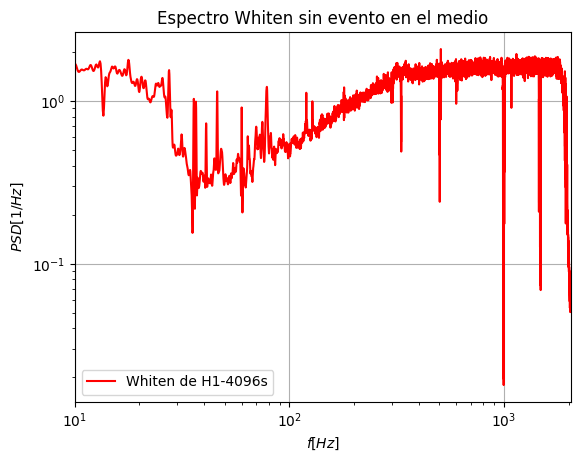

In [149]:
x = whiten(data['H1_4096'], event = False)

L_seg = 3
L = int(L_seg * fs)
Rxx1, w1 = periodogram_smoothing(x, L, N_FFT = np.max([50000, 2*(L)+ 1]), window = 'parzen')
f1 = w1 * fs / (2*np.pi)
plt.plot(f1, Rxx1, color = 'r', label = 'Whiten de H1-4096s')

plt.title('Espectro Whiten sin evento en el medio')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$f[Hz]$')
plt.ylabel('$PSD[1/Hz]$')
plt.legend(loc = 'lower left')
plt.xlim(10, fs/2)
#plt.ylim(10**(-48), 10**(-34))
plt.grid(True)
plt.show()

Se observa que el espectro no es completamente plano como se esperaba, incluso hay frecuencias especificas que fueron muy atenuadas.

## Audio del evento

In [150]:
Audio((filtered_signal_phase_H1 - np.mean(filtered_signal_phase_H1))/ np.max((filtered_signal_phase_H1 - np.mean(filtered_signal_phase_H1))), rate=fs)

# Correlación Cruzada

Delta T =  0.00732421875


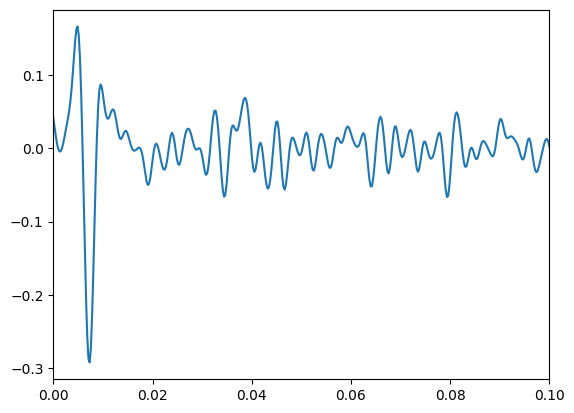

In [155]:
start_index = np.where((time > 0.38) & (time < 0.39))[0][0]
win_h1 = filtered_signal_phase_H1[start_index:start_index +  int(0.2*fs)]
win_l1 = filtered_signal_phase2_L1[start_index: start_index + int(0.2*fs)]

lags_time = signal.correlation_lags(len(win_h1), len(win_l1)) / fs

xcorr = biased_xcorr(np.real(win_h1), np.real(win_l1))

plt.figure()
plt.plot(lags_time, xcorr)
plt.xlim(0, 0.1)
idx = np.where(lags_time == 0)[0][0]
print('Delta T = ', lags_time[idx + np.argmin(xcorr[idx:])])

El delta T medido es el esperado.

# Ángulo de arribo de la señal

La distancia no geodésica, es 3030.1 km ...